# Fictitious Degradation Dataset
For each experiment and for each loading condition there are different degradation paths that have some common
characteristics which we should discover.


In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
import numpy as np
import matplotlib.pyplot as pplot
tfd = tfp.distributions
from ipywidgets import FloatSlider, IntSlider, interact, interactive


from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras import Sequential,Model
import tensorflow.keras as keras


config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)

In [2]:
from utils import get_indices, data_from_experiment, get_graph_data, get_graph_data_multiple_experiments, get_multi_batch

In [3]:
## imports that are related to the fictitious dataset:

from datasets.fictitious_dataset import lhs_sample,transform_exp_data_to_random_signal_params,add_disturbances_in_signal,get_dat, make_experiments_3conditions

In [4]:
latent = make_experiments_3conditions(nexp_per_case=10)
help(make_experiments_3conditions)

Help on function make_experiments_3conditions in module datasets.fictitious_dataset:

make_experiments_3conditions(nexp_per_case=1, base_rate=1.0, rates_shift=-0.5, base_concentration=3.0, concentration_shifts=0.2)
    This function creates the latent variable for all cases. 
    
    When the cummulative latent variable passes a threshold failure occurs.
    The returned experiments correspond to 3 damage evolution regimes.
    These parameters were hand-picked so that the evolution is aligned with 
    some assumptions on the evolution of damage, have sufficient 
    variation to make the problem non-trivial, and have sufficient 
    variation between the 3 evolution cases.  In future implementations it may be 
    interesting to combine evolution regimes for representing arbitrary loading.



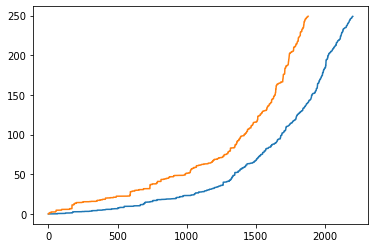

In [5]:
pplot.plot(latent[0]['latent_values'])
pplot.plot(latent[2]['latent_values'])


In [6]:
from datasets.fictitious_dataset import get_signal_for_segments

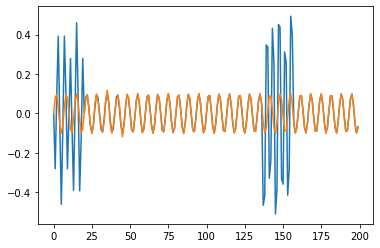

In [7]:
ss = get_signal_for_segments(latent[0]['latent_values'], speed = 150, rr=10)
pplot.plot(ss[-10,0:200])
pplot.plot(ss[10,0:200])


In [8]:
# for k in latent:
#     print(k)
#     pplot.plot(k['latent_values'])

In [9]:
latent = make_experiments_3conditions(nexp_per_case=10)


all_exp_dat = []
rr = 10
def reshape_ttf(v):
    if v.shape[0]%rr == 0:
        return np.mean(v.reshape([-1,rr]),1)
    else:
        return np.mean(v[:-(v.shape[0]%rr)].reshape([-1,rr]),1)
        
for d in latent:
    l = d['latent_values']
    ttf =d['ttf']
    
    y = reshape_ttf(ttf)
    case = d['case']
    speed_dict = {0:20, 1:25, 2:30}; # This is to superimpose a salient, yet irrelevant feature in the time-series.
                                     # Internally the network is expected to exploit this feature 
    if y.shape[0] == 0:
        break
    X = get_signal_for_segments(l, speed= speed_dict[case])
    eid = d['exp_index']

    exp_data = {
        "X" : X ,
        "eid" : (np.ones([X.shape[0],1]) * eid).astype(int),
        "y" : y,
        "case" : np.ones([X.shape[0],1]) * case
    }

    all_exp_dat.append(exp_data)

    

In [10]:
from datasets.fictitious_dataset import FictitiousDataset


In [11]:
fic=  FictitiousDataset(n_exp_per_case=5,pct_val_set=0.12,)


Created random data for fictitious experiment.
training experiments: 12 , testing 3


In [12]:
fic.X.shape,fic.y.shape, fic.cases.shape

((3182, 1000, 1), (3182, 1), (3182, 1))

In [13]:
def get_multi_batch_fictitious(*args, **kwargs):
    new_args = (args[0], fic)
    return get_multi_batch(*new_args, **kwargs)


In [14]:
d = get_multi_batch(4,fic, nseq_range=100, nnodes = 5, min_spacing=2)

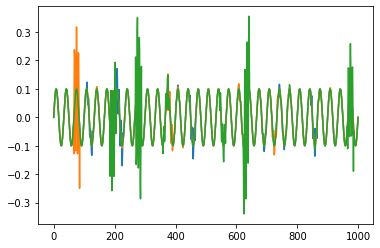

In [15]:
pplot.plot(exp_data['X'][0,:])
pplot.plot(exp_data['X'][10,:])
pplot.plot(exp_data['X'][100,:])


## Mini - graphnets
* **Edge**: Object keeping edge data - in this example dt and a latent output from the sender node.
* **Node**: Object keeping node data - in this example a latent variable (some function of observation and edge output).
* **Graph**: An object keeping edges/nodes corresponding to sequences of observations (and predictions?)
* **GraphNet**: An object defining how the computation happens on a graph object. It is a sequence of transformations and aggregations performed on edge and node states.

The information flowing through the graph may be better implemented in a sequential MC way. The nodes output samples or distributions, that are propagated by the edge to the time-instant corresponding to the receiver node. The edge aggregation function can be the application of Bayes rule in some way. 

## Utilities to make construction easier

## Classes for `Node` and `Edge` and `Graph`
These are classes encapsulating the attributes corresponding objects. Their behavior and the functions mutating them are implemented in a separate class (`GraphNet`) so that the graphNet can be evaluated with arbitrary graphs.

In [16]:
from minigraphnets import *

In [17]:
from graphnet_utils import GraphNetFunctionFactory
gn_tot = GraphNetFunctionFactory(channels_in =  1, 
                                 n_conv_blocks=2, 
                                 nfilts=32, 
                                 nfilts2=64,
                                 network_size_global = 100)

In [18]:
gn_tot.load("/tmp/GraphNet_Fictitious")

loading /tmp/GraphNet_Fictitious/core/node_function
loading /tmp/GraphNet_Fictitious/core/edge_aggregation_function
loading /tmp/GraphNet_Fictitious/core/edge_function
loading /tmp/GraphNet_Fictitious/core/node_to_prob
loading /tmp/GraphNet_Fictitious/graph_independent/node_function
path /tmp/GraphNet_Fictitious/graph_independent/edge_aggregation_function does not exist! Function edge_aggregation_function will not be constructed.
loading /tmp/GraphNet_Fictitious/graph_independent/edge_function
path /tmp/GraphNet_Fictitious/graph_independent/node_to_prob does not exist! Function node_to_prob will not be constructed.


In [19]:
#gn_tot.make_graphnet_comp_blocks(fic.X[0].shape[0])


In [46]:
n1 = Node(np.random.randn(1,1234,1))
n2 = Node(np.random.randn(1,1234,1))
e12 = Edge(np.random.randn(1,1,1) , n1,n2)
g = Graph([n1,n2],[e12])
v = gn_tot.eval_graphnets(g, return_intermediate_graphs=True)

<class 'minigraphnets.Graph'>
<class 'minigraphnets.Graph'>
<class 'minigraphnets.Graph'>
<class 'minigraphnets.Graph'>
<class 'minigraphnets.Graph'>


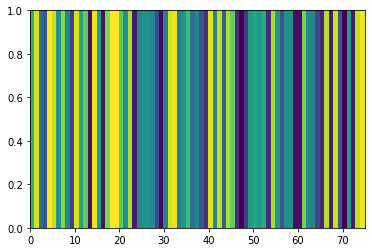

In [36]:
g2 = g.copy()
v = []
for e1,e2 in zip(g2.edges , g.edges):
    v.append(np.linalg.norm(e1.edge_tensor - e2.edge_tensor))
    
v

[0.0]

In [37]:
v = tf.Variable(np.random.randn(10,10))
v.numpy().copy()

array([[ 1.52305607,  0.84528729, -1.69600045, -0.21578548, -0.31664072,
         0.41782449, -1.02691703, -0.96282123, -0.58138633, -0.75222287],
       [-1.63982013, -1.40495267,  0.96123152,  0.13352692,  0.26603378,
         0.12747154,  0.20292141, -1.54696779, -1.11092875, -1.66315644],
       [-0.79164616, -0.14809502,  0.52383239,  0.15912043, -2.39063268,
         0.00889654, -0.0123728 ,  0.69951095,  1.32294854,  0.15039298],
       [ 0.12770889, -1.02845126, -0.38724224, -0.3388649 , -0.81999138,
        -0.14909139, -1.9936992 ,  0.31698297,  0.45217524, -0.73719765],
       [-0.17445138, -1.08730781,  0.43996763,  0.51989992, -0.86217445,
         1.40197688,  0.6355489 , -1.28991398,  0.48643759, -1.79900656],
       [ 1.50980166,  0.39000506,  0.59750652,  1.51798345, -0.17795911,
         0.71490878, -0.51521164,  1.47329282,  0.0107844 ,  0.97455459],
       [-0.61663324, -0.72400602, -0.31386894, -2.10401721, -0.16529886,
        -0.35240257,  0.78661397, -0.64922523

In [42]:
help(type(tf.python.framework.ops.EagerTensor))

Help on class type in module builtins:

class type(object)
 |  type(object_or_name, bases, dict)
 |  type(object) -> the object's type
 |  type(name, bases, dict) -> a new type
 |  
 |  Methods defined here:
 |  
 |  __call__(self, /, *args, **kwargs)
 |      Call self as a function.
 |  
 |  __delattr__(self, name, /)
 |      Implement delattr(self, name).
 |  
 |  __dir__(...)
 |      __dir__() -> list
 |      specialized __dir__ implementation for types
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __instancecheck__(...)
 |      __instancecheck__() -> bool
 |      check if an object is an instance
 |  
 |  __new__(*args, **kwargs)
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __prepare__(...)
 |      __prepare__() -> dict
 |      used to create the namespace for the class statement
 |  
 


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



False

## The basic idea:
[alt-text](temporal_bayesian_graphnet.png)
Assuming this is markovian and I can capture something about the markov state with $z_i$, perhaps the second order links are not needed. Some more insight from what people in RL are using is needed to resolve this. 


### In more detail
* The input data, namely the raw time-series inputs and the difference in times for the observations,  are first transformed. The time-differences are simply projected to a 15 dimensional scalar and the time-series input is transformed using a convolutional neural network with global pooling to a 15 dimensional vector. 

* A second graph-net, that contains the causal links between the nodes of the graph, is then used to process the embedded quantities.
* The final inferred state is used to define the parameters of a `DistributionLambda` layer that is finally used to compute the final output. The final output is the time to failure for the final observation.

### Extensions
With adversarial learning the GraphNet should be able to infer prediction dependent and prediction independent states. This complicates implemetation (adversarial graph-nets would be yet another novel thing).

In [29]:
train_data = get_graph_data_multiple_experiments([0,2,3],fic.X, eid_oh_ = fic.eid_oh, yrem_norm_ = fic.yrem_norm ,
                                   nsamples_per_experiment = 50, nnodes = 5, min_spacing = 3, nseq_range=100)
gg_ = train_data[0][0]
predictions = train_data[0][1]

In [21]:
if False:
    gg_.edges[-1].edge_tensor.flatten().shape, predictions
    #gg_.edges[1].edge_tensor-gg_.edges[0].edge_tensor
    pplot.plot(gg_.edges[0].edge_tensor.flatten(),predictions.flatten(),'.')

## A cleaner training loop (with some standard training tricks)

In [22]:
from utils_train import EarlyStopping, LRScheduler, LossLogger
learning_rate = 0.001;
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
loss_log = LossLogger()
early_stop = EarlyStopping(150,loss_log.loss_history['val_loss'])
lr_scheduler = LRScheduler(opt, epoch_decay = 40, decay_rate = 0.99)

In [22]:
def eval_quantile(distr ,q, nsamples = 500):
    return np.quantile(distr.sample(nsamples),q,0)

def eval_graphnets(graph_in, iterations = 5):
    return gn_tot.eval_graphnets(graph_in.copy(), iterations = 5)

def plot_experiment_fit(graph_and_result_tuple, iterations =  5,
                        max_time = None,
                        colorscale_fn = lambda x : x, **kwargs):
    #ind_exp = 0;
    y = graph_and_result_tuple[1]
    
    if max_time is None:
        max_time = np.max(y)*1.5
    
    t_probs= np.linspace(0,max_time,102)
    distribution = eval_graphnets(graph_and_result_tuple[0])
    v = distribution.prob(t_probs).numpy().T    
    q1=eval_quantile(distribution,0.1)
    qm=eval_quantile(distribution,0.5)
    q2=eval_quantile(distribution,0.9)
    
    ids_sort = np.argsort(y.flatten());
    ysort = y[ids_sort.flatten()]
    xxvals = np.array([i for i in range(ysort.shape[0])])
    [xx,yy] = np.meshgrid(xxvals,t_probs)
    pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)
    pplot.plot(xxvals,y[ids_sort.flatten()],'C0-', linewidth = 3)
    pplot.plot(xxvals,q1[ids_sort],'C1-.')
    pplot.plot(xxvals,q2[ids_sort],'C1-.')
    pplot.plot(xxvals,qm[ids_sort],'C1-')
    
    pplot.xlabel("Sample")
    pplot.ylabel("RUL[s]")
    return v[:,ids_sort], q1,q2, distribution
    
yy,q1,q2,d  = plot_experiment_fit( train_data[0], colorscale_fn=lambda x : x ** 0.5,  cmap = "gray")
#pplot.plot(q1)



NameError: name 'train_data' is not defined

In [23]:
#gn_tot.eval_graphnets(train_data[0][0]).sample(1)

  0%|          | 0/200 [00:00<?, ?it/s]

nnodes: 1, seq_range 2 epoch: 0
loss: 11.549, val_loss 11.549
burn-in:  setting lr to 0.00000


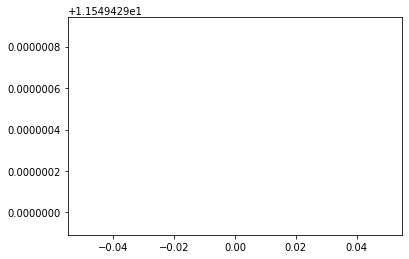

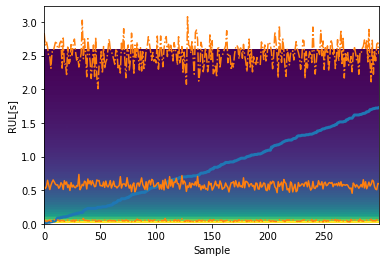

  0%|          | 1/200 [00:09<30:07,  9.08s/it]

nnodes: 2, seq_range 20 epoch: 1


  1%|          | 2/200 [00:18<30:01,  9.10s/it]

loss: 11.512, val_loss 11.512
burn-in:  setting lr to 0.00010
nnodes: 5, seq_range 50 epoch: 2


  2%|▏         | 3/200 [00:29<31:36,  9.63s/it]

loss: 10.082, val_loss 10.082
burn-in:  setting lr to 0.00020
nnodes: 10, seq_range 100 epoch: 3


  2%|▏         | 4/200 [00:42<35:18, 10.81s/it]

loss: 7.094, val_loss 7.095
burn-in:  setting lr to 0.00030
nnodes: 1, seq_range 2 epoch: 4


  2%|▎         | 5/200 [00:43<25:38,  7.89s/it]

loss: 11.228, val_loss 11.228
burn-in:  setting lr to 0.00040
nnodes: 2, seq_range 20 epoch: 5


  3%|▎         | 6/200 [00:45<19:16,  5.96s/it]

loss: 8.539, val_loss 8.539
burn-in:  setting lr to 0.00050
nnodes: 5, seq_range 50 epoch: 6


  4%|▎         | 7/200 [00:47<15:29,  4.82s/it]

loss: 6.407, val_loss 6.407
burn-in:  setting lr to 0.00060
nnodes: 10, seq_range 100 epoch: 7


  4%|▍         | 8/200 [00:50<13:37,  4.26s/it]

loss: 2.171, val_loss 2.171
burn-in:  setting lr to 0.00070
nnodes: 1, seq_range 2 epoch: 8


  4%|▍         | 9/200 [00:51<10:36,  3.33s/it]

loss: 9.731, val_loss 9.731
burn-in:  setting lr to 0.00080
nnodes: 2, seq_range 20 epoch: 9


  5%|▌         | 10/200 [00:53<08:53,  2.81s/it]

loss: 7.336, val_loss 7.336
burn-in:  setting lr to 0.00090
nnodes: 5, seq_range 50 epoch: 10
loss: 5.726, val_loss 5.726
burn-in:  setting lr to 0.00100


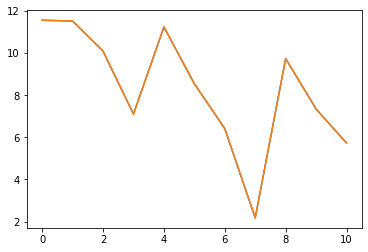

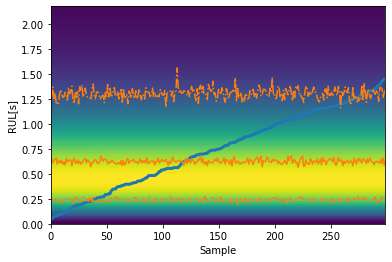

  6%|▌         | 11/200 [00:55<08:52,  2.82s/it]

nnodes: 10, seq_range 100 epoch: 11


  6%|▌         | 12/200 [00:58<08:57,  2.86s/it]

loss: 1.713, val_loss 1.713
nnodes: 1, seq_range 2 epoch: 12


  6%|▋         | 13/200 [00:59<07:18,  2.34s/it]

loss: 8.936, val_loss 8.936
nnodes: 2, seq_range 20 epoch: 13


  7%|▋         | 14/200 [01:01<06:30,  2.10s/it]

loss: 7.117, val_loss 7.117
nnodes: 5, seq_range 50 epoch: 14


  8%|▊         | 15/200 [01:03<06:20,  2.06s/it]

loss: 3.157, val_loss 3.157
nnodes: 10, seq_range 100 epoch: 15


  8%|▊         | 16/200 [01:06<07:20,  2.40s/it]

loss: 0.437, val_loss 0.437
nnodes: 1, seq_range 2 epoch: 16


  8%|▊         | 17/200 [01:07<06:05,  2.00s/it]

loss: 7.742, val_loss 7.742
nnodes: 2, seq_range 20 epoch: 17


  9%|▉         | 18/200 [01:09<05:34,  1.84s/it]

loss: 5.523, val_loss 5.523
nnodes: 5, seq_range 50 epoch: 18


 10%|▉         | 19/200 [01:11<05:39,  1.88s/it]

loss: 3.308, val_loss 3.308
nnodes: 10, seq_range 100 epoch: 19


 10%|█         | 20/200 [01:14<06:31,  2.18s/it]

loss: -1.860, val_loss -1.860
nnodes: 1, seq_range 2 epoch: 20
loss: 4.811, val_loss 4.811


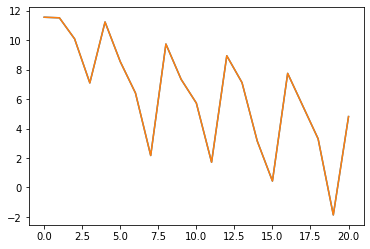

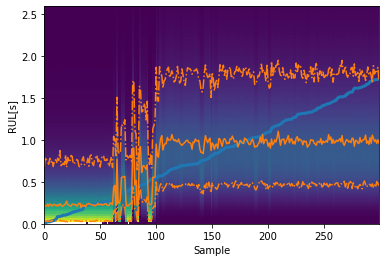

 10%|█         | 21/200 [01:15<06:14,  2.09s/it]

nnodes: 2, seq_range 20 epoch: 21


 11%|█         | 22/200 [01:17<05:37,  1.90s/it]

loss: 3.266, val_loss 3.266
nnodes: 5, seq_range 50 epoch: 22


 12%|█▏        | 23/200 [01:19<05:38,  1.91s/it]

loss: -0.110, val_loss -0.110
nnodes: 10, seq_range 100 epoch: 23


 12%|█▏        | 24/200 [01:22<06:36,  2.26s/it]

loss: -2.125, val_loss -2.125
nnodes: 1, seq_range 2 epoch: 24


 12%|█▎        | 25/200 [01:23<05:32,  1.90s/it]

loss: 2.343, val_loss 2.343
nnodes: 2, seq_range 20 epoch: 25


 13%|█▎        | 26/200 [01:24<05:05,  1.76s/it]

loss: 1.420, val_loss 1.420
nnodes: 5, seq_range 50 epoch: 26


 14%|█▎        | 27/200 [01:26<05:16,  1.83s/it]

loss: -0.904, val_loss -0.904
nnodes: 10, seq_range 100 epoch: 27


 14%|█▍        | 28/200 [01:29<06:17,  2.19s/it]

loss: -1.999, val_loss -1.999
nnodes: 1, seq_range 2 epoch: 28


 14%|█▍        | 29/200 [01:30<05:15,  1.84s/it]

loss: 4.029, val_loss 4.029
nnodes: 2, seq_range 20 epoch: 29


 15%|█▌        | 30/200 [01:32<04:52,  1.72s/it]

loss: 1.346, val_loss 1.346
nnodes: 5, seq_range 50 epoch: 30
loss: -1.167, val_loss -1.167


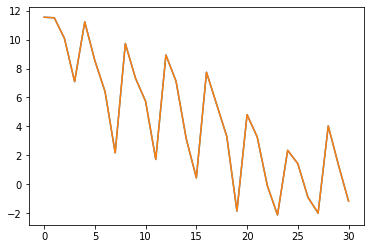

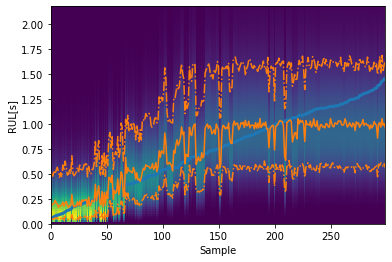

 16%|█▌        | 31/200 [01:35<05:47,  2.06s/it]

nnodes: 10, seq_range 100 epoch: 31


 16%|█▌        | 32/200 [01:38<06:23,  2.28s/it]

loss: -3.618, val_loss -3.618
nnodes: 1, seq_range 2 epoch: 32


 16%|█▋        | 33/200 [01:39<05:20,  1.92s/it]

loss: 2.306, val_loss 2.306
nnodes: 2, seq_range 20 epoch: 33


 17%|█▋        | 34/200 [01:40<04:51,  1.76s/it]

loss: 0.382, val_loss 0.382
nnodes: 5, seq_range 50 epoch: 34


 18%|█▊        | 35/200 [01:42<05:04,  1.84s/it]

loss: -1.995, val_loss -1.995
nnodes: 10, seq_range 100 epoch: 35


 18%|█▊        | 36/200 [01:45<05:49,  2.13s/it]

loss: -4.354, val_loss -4.354
nnodes: 1, seq_range 2 epoch: 36


 18%|█▊        | 37/200 [01:46<04:52,  1.79s/it]

loss: 1.577, val_loss 1.577
nnodes: 2, seq_range 20 epoch: 37


 19%|█▉        | 38/200 [01:47<04:39,  1.73s/it]

loss: -0.166, val_loss -0.166
nnodes: 5, seq_range 50 epoch: 38


 20%|█▉        | 39/200 [01:50<04:57,  1.85s/it]

loss: -1.998, val_loss -1.998
nnodes: 10, seq_range 100 epoch: 39


 20%|██        | 40/200 [01:53<05:51,  2.19s/it]

loss: -4.518, val_loss -4.518
nnodes: 1, seq_range 2 epoch: 40
loss: 0.842, val_loss 0.842
lr_decay: setting lr to 0.00099


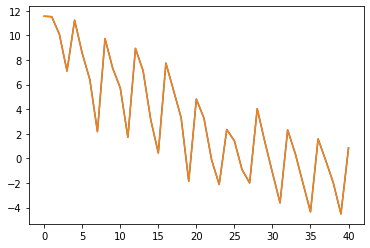

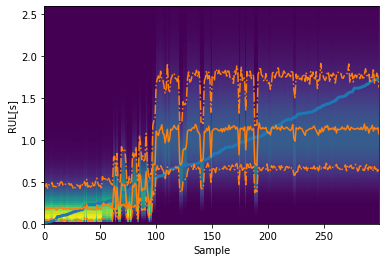

 20%|██        | 41/200 [01:54<05:31,  2.08s/it]

nnodes: 2, seq_range 20 epoch: 41


 21%|██        | 42/200 [01:56<04:57,  1.89s/it]

loss: -0.657, val_loss -0.657
lr_decay: setting lr to 0.00098
nnodes: 5, seq_range 50 epoch: 42


 22%|██▏       | 43/200 [01:58<04:59,  1.91s/it]

loss: -2.648, val_loss -2.648
lr_decay: setting lr to 0.00097
nnodes: 10, seq_range 100 epoch: 43


 22%|██▏       | 44/200 [02:01<05:42,  2.19s/it]

loss: -5.010, val_loss -5.010
lr_decay: setting lr to 0.00096
nnodes: 1, seq_range 2 epoch: 44


 22%|██▎       | 45/200 [02:02<04:48,  1.86s/it]

loss: 0.620, val_loss 0.620
lr_decay: setting lr to 0.00095
nnodes: 2, seq_range 20 epoch: 45


 23%|██▎       | 46/200 [02:03<04:25,  1.72s/it]

loss: -1.172, val_loss -1.172
lr_decay: setting lr to 0.00094
nnodes: 5, seq_range 50 epoch: 46


 24%|██▎       | 47/200 [02:05<04:33,  1.79s/it]

loss: -2.597, val_loss -2.597
lr_decay: setting lr to 0.00093
nnodes: 10, seq_range 100 epoch: 47


 24%|██▍       | 48/200 [02:08<05:17,  2.09s/it]

loss: -4.393, val_loss -4.393
lr_decay: setting lr to 0.00092
nnodes: 1, seq_range 2 epoch: 48


 24%|██▍       | 49/200 [02:09<04:26,  1.77s/it]

loss: 0.648, val_loss 0.648
lr_decay: setting lr to 0.00091
nnodes: 2, seq_range 20 epoch: 49


 25%|██▌       | 50/200 [02:10<04:08,  1.65s/it]

loss: -0.596, val_loss -0.596
lr_decay: setting lr to 0.00090
nnodes: 5, seq_range 50 epoch: 50
loss: -2.797, val_loss -2.797
lr_decay: setting lr to 0.00090


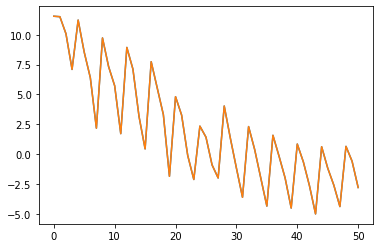

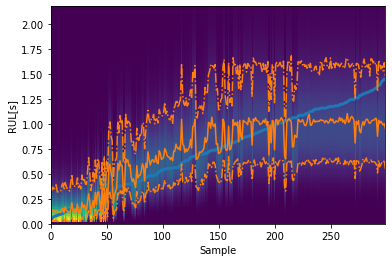

 26%|██▌       | 51/200 [02:13<05:01,  2.02s/it]

nnodes: 10, seq_range 100 epoch: 51


 26%|██▌       | 52/200 [02:16<05:32,  2.25s/it]

loss: -4.832, val_loss -4.832
lr_decay: setting lr to 0.00089
nnodes: 1, seq_range 2 epoch: 52


 26%|██▋       | 53/200 [02:17<04:39,  1.90s/it]

loss: 2.286, val_loss 2.286
lr_decay: setting lr to 0.00088
nnodes: 2, seq_range 20 epoch: 53


 27%|██▋       | 54/200 [02:18<04:15,  1.75s/it]

loss: -0.385, val_loss -0.385
lr_decay: setting lr to 0.00087
nnodes: 5, seq_range 50 epoch: 54


 28%|██▊       | 55/200 [02:20<04:21,  1.81s/it]

loss: -2.432, val_loss -2.432
lr_decay: setting lr to 0.00086
nnodes: 10, seq_range 100 epoch: 55


 28%|██▊       | 56/200 [02:23<05:02,  2.10s/it]

loss: -5.200, val_loss -5.200
lr_decay: setting lr to 0.00085
nnodes: 1, seq_range 2 epoch: 56


 28%|██▊       | 57/200 [02:24<04:15,  1.79s/it]

loss: 2.603, val_loss 2.603
lr_decay: setting lr to 0.00084
nnodes: 2, seq_range 20 epoch: 57


 29%|██▉       | 58/200 [02:26<03:58,  1.68s/it]

loss: 0.072, val_loss 0.072
lr_decay: setting lr to 0.00083
nnodes: 5, seq_range 50 epoch: 58


 30%|██▉       | 59/200 [02:27<04:07,  1.76s/it]

loss: -2.714, val_loss -2.714
lr_decay: setting lr to 0.00083
nnodes: 10, seq_range 100 epoch: 59


 30%|███       | 60/200 [02:30<04:57,  2.13s/it]

loss: -5.053, val_loss -5.053
lr_decay: setting lr to 0.00082
nnodes: 1, seq_range 2 epoch: 60
loss: 0.774, val_loss 0.774
lr_decay: setting lr to 0.00081


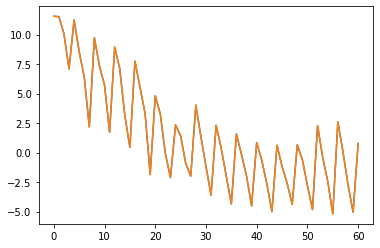

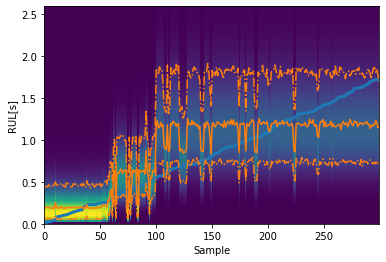

 30%|███       | 61/200 [02:32<04:39,  2.01s/it]

nnodes: 2, seq_range 20 epoch: 61


 31%|███       | 62/200 [02:34<04:14,  1.84s/it]

loss: -0.738, val_loss -0.738
lr_decay: setting lr to 0.00080
nnodes: 5, seq_range 50 epoch: 62


 32%|███▏      | 63/200 [02:36<04:13,  1.85s/it]

loss: -3.215, val_loss -3.215
lr_decay: setting lr to 0.00079
nnodes: 10, seq_range 100 epoch: 63


 32%|███▏      | 64/200 [02:38<04:53,  2.16s/it]

loss: -5.829, val_loss -5.829
lr_decay: setting lr to 0.00079
nnodes: 1, seq_range 2 epoch: 64


 32%|███▎      | 65/200 [02:39<04:05,  1.82s/it]

loss: 0.304, val_loss 0.304
lr_decay: setting lr to 0.00078
nnodes: 2, seq_range 20 epoch: 65


 33%|███▎      | 66/200 [02:41<03:47,  1.70s/it]

loss: -1.284, val_loss -1.284
lr_decay: setting lr to 0.00077
nnodes: 5, seq_range 50 epoch: 66


 34%|███▎      | 67/200 [02:43<03:54,  1.76s/it]

loss: -3.090, val_loss -3.090
lr_decay: setting lr to 0.00076
nnodes: 10, seq_range 100 epoch: 67


 34%|███▍      | 68/200 [02:46<04:33,  2.07s/it]

loss: -5.919, val_loss -5.919
lr_decay: setting lr to 0.00075
nnodes: 1, seq_range 2 epoch: 68


 34%|███▍      | 69/200 [02:47<03:54,  1.79s/it]

loss: -0.279, val_loss -0.279
lr_decay: setting lr to 0.00075
nnodes: 2, seq_range 20 epoch: 69


 35%|███▌      | 70/200 [02:48<03:37,  1.67s/it]

loss: -1.379, val_loss -1.379
lr_decay: setting lr to 0.00074
nnodes: 5, seq_range 50 epoch: 70
loss: -3.450, val_loss -3.450
lr_decay: setting lr to 0.00073


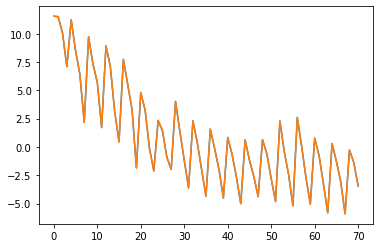

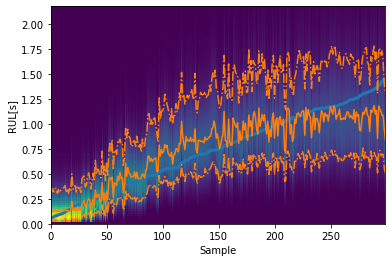

 36%|███▌      | 71/200 [02:51<04:15,  1.98s/it]

nnodes: 10, seq_range 100 epoch: 71


 36%|███▌      | 72/200 [02:54<04:50,  2.27s/it]

loss: -6.122, val_loss -6.122
lr_decay: setting lr to 0.00072
nnodes: 1, seq_range 2 epoch: 72


 36%|███▋      | 73/200 [02:55<04:02,  1.91s/it]

loss: -0.348, val_loss -0.348
lr_decay: setting lr to 0.00072
nnodes: 2, seq_range 20 epoch: 73


 37%|███▋      | 74/200 [02:56<03:40,  1.75s/it]

loss: -1.607, val_loss -1.607
lr_decay: setting lr to 0.00071
nnodes: 5, seq_range 50 epoch: 74


 38%|███▊      | 75/200 [02:58<03:45,  1.80s/it]

loss: -3.626, val_loss -3.626
lr_decay: setting lr to 0.00070
nnodes: 10, seq_range 100 epoch: 75


 38%|███▊      | 76/200 [03:01<04:22,  2.11s/it]

loss: -6.478, val_loss -6.478
lr_decay: setting lr to 0.00070
nnodes: 1, seq_range 2 epoch: 76


 38%|███▊      | 77/200 [03:02<03:40,  1.80s/it]

loss: -0.407, val_loss -0.407
lr_decay: setting lr to 0.00069
nnodes: 2, seq_range 20 epoch: 77


 39%|███▉      | 78/200 [03:03<03:24,  1.68s/it]

loss: -1.705, val_loss -1.705
lr_decay: setting lr to 0.00068
nnodes: 5, seq_range 50 epoch: 78


 40%|███▉      | 79/200 [03:05<03:33,  1.76s/it]

loss: -3.676, val_loss -3.676
lr_decay: setting lr to 0.00068
nnodes: 10, seq_range 100 epoch: 79


 40%|████      | 80/200 [03:08<04:14,  2.12s/it]

loss: -6.416, val_loss -6.416
lr_decay: setting lr to 0.00067
nnodes: 1, seq_range 2 epoch: 80
loss: -0.720, val_loss -0.720
lr_decay: setting lr to 0.00066


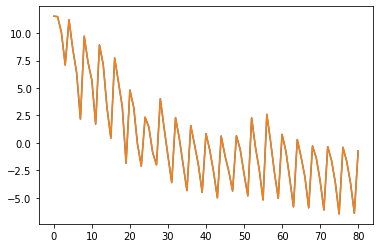

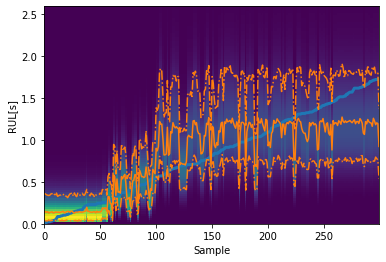

 40%|████      | 81/200 [03:10<03:58,  2.01s/it]

nnodes: 2, seq_range 20 epoch: 81


 41%|████      | 82/200 [03:11<03:34,  1.82s/it]

loss: -1.836, val_loss -1.836
lr_decay: setting lr to 0.00066
nnodes: 5, seq_range 50 epoch: 82


 42%|████▏     | 83/200 [03:14<03:41,  1.89s/it]

loss: -4.088, val_loss -4.088
lr_decay: setting lr to 0.00065
nnodes: 10, seq_range 100 epoch: 83


 42%|████▏     | 84/200 [03:16<04:11,  2.17s/it]

loss: -6.701, val_loss -6.701
lr_decay: setting lr to 0.00064
nnodes: 1, seq_range 2 epoch: 84


 42%|████▎     | 85/200 [03:17<03:29,  1.82s/it]

loss: -0.885, val_loss -0.885
lr_decay: setting lr to 0.00064
nnodes: 2, seq_range 20 epoch: 85


 43%|████▎     | 86/200 [03:19<03:13,  1.70s/it]

loss: -1.954, val_loss -1.954
lr_decay: setting lr to 0.00063
nnodes: 5, seq_range 50 epoch: 86


 44%|████▎     | 87/200 [03:21<03:19,  1.77s/it]

loss: -3.651, val_loss -3.651
lr_decay: setting lr to 0.00062
nnodes: 10, seq_range 100 epoch: 87


 44%|████▍     | 88/200 [03:24<03:56,  2.11s/it]

loss: -6.348, val_loss -6.348
lr_decay: setting lr to 0.00062
nnodes: 1, seq_range 2 epoch: 88


 44%|████▍     | 89/200 [03:25<03:18,  1.79s/it]

loss: -0.440, val_loss -0.440
lr_decay: setting lr to 0.00061
nnodes: 2, seq_range 20 epoch: 89


 45%|████▌     | 90/200 [03:26<03:02,  1.66s/it]

loss: -1.913, val_loss -1.913
lr_decay: setting lr to 0.00061
nnodes: 5, seq_range 50 epoch: 90
loss: -4.020, val_loss -4.020
lr_decay: setting lr to 0.00060


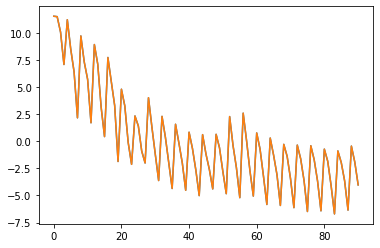

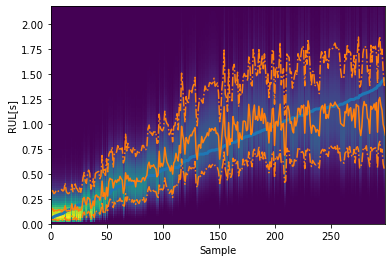

 46%|████▌     | 91/200 [03:29<03:35,  1.98s/it]

nnodes: 10, seq_range 100 epoch: 91


 46%|████▌     | 92/200 [03:32<04:02,  2.25s/it]

loss: -6.882, val_loss -6.882
lr_decay: setting lr to 0.00059
nnodes: 1, seq_range 2 epoch: 92


 46%|████▋     | 93/200 [03:33<03:20,  1.87s/it]

loss: -1.295, val_loss -1.295
lr_decay: setting lr to 0.00059
nnodes: 2, seq_range 20 epoch: 93


 47%|████▋     | 94/200 [03:34<03:04,  1.74s/it]

loss: -2.063, val_loss -2.063
lr_decay: setting lr to 0.00058
nnodes: 5, seq_range 50 epoch: 94


 48%|████▊     | 95/200 [03:36<03:08,  1.80s/it]

loss: -4.117, val_loss -4.117
lr_decay: setting lr to 0.00058
nnodes: 10, seq_range 100 epoch: 95


 48%|████▊     | 96/200 [03:39<03:37,  2.09s/it]

loss: -6.748, val_loss -6.748
lr_decay: setting lr to 0.00057
nnodes: 1, seq_range 2 epoch: 96


 48%|████▊     | 97/200 [03:40<03:04,  1.80s/it]

loss: -0.996, val_loss -0.996
lr_decay: setting lr to 0.00056
nnodes: 2, seq_range 20 epoch: 97


 49%|████▉     | 98/200 [03:41<02:51,  1.68s/it]

loss: -2.153, val_loss -2.153
lr_decay: setting lr to 0.00056
nnodes: 5, seq_range 50 epoch: 98


 50%|████▉     | 99/200 [03:43<02:58,  1.77s/it]

loss: -3.890, val_loss -3.890
lr_decay: setting lr to 0.00055
nnodes: 10, seq_range 100 epoch: 99


 50%|█████     | 100/200 [03:46<03:26,  2.06s/it]

loss: -7.028, val_loss -7.028
lr_decay: setting lr to 0.00055
nnodes: 1, seq_range 2 epoch: 100
loss: -1.083, val_loss -1.083
lr_decay: setting lr to 0.00054


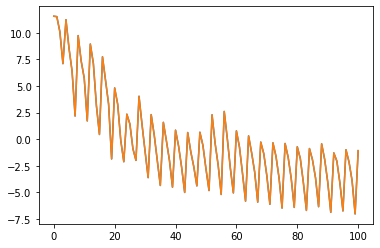

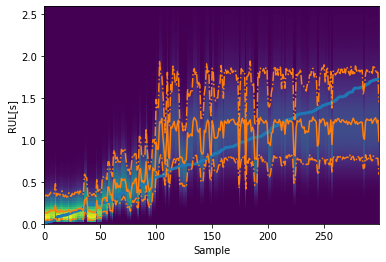

 50%|█████     | 101/200 [03:48<03:18,  2.01s/it]

nnodes: 2, seq_range 20 epoch: 101


 51%|█████     | 102/200 [03:49<02:59,  1.83s/it]

loss: -2.201, val_loss -2.201
lr_decay: setting lr to 0.00054
nnodes: 5, seq_range 50 epoch: 102


 52%|█████▏    | 103/200 [03:51<03:01,  1.87s/it]

loss: -4.486, val_loss -4.486
lr_decay: setting lr to 0.00053
nnodes: 10, seq_range 100 epoch: 103


 52%|█████▏    | 104/200 [03:54<03:26,  2.15s/it]

loss: -7.097, val_loss -7.097
lr_decay: setting lr to 0.00053
nnodes: 1, seq_range 2 epoch: 104


 52%|█████▎    | 105/200 [03:55<02:52,  1.81s/it]

loss: -1.346, val_loss -1.346
lr_decay: setting lr to 0.00052
nnodes: 2, seq_range 20 epoch: 105


 53%|█████▎    | 106/200 [03:56<02:38,  1.69s/it]

loss: -2.122, val_loss -2.122
lr_decay: setting lr to 0.00052
nnodes: 5, seq_range 50 epoch: 106


 54%|█████▎    | 107/200 [03:58<02:43,  1.76s/it]

loss: -4.309, val_loss -4.309
lr_decay: setting lr to 0.00051
nnodes: 10, seq_range 100 epoch: 107


 54%|█████▍    | 108/200 [04:01<03:15,  2.12s/it]

loss: -6.986, val_loss -6.986
lr_decay: setting lr to 0.00050
nnodes: 1, seq_range 2 epoch: 108


 55%|█████▍    | 109/200 [04:02<02:43,  1.79s/it]

loss: -1.296, val_loss -1.296
lr_decay: setting lr to 0.00050
nnodes: 2, seq_range 20 epoch: 109


 55%|█████▌    | 110/200 [04:04<02:30,  1.68s/it]

loss: -2.313, val_loss -2.313
lr_decay: setting lr to 0.00049
nnodes: 5, seq_range 50 epoch: 110
loss: -4.534, val_loss -4.534
lr_decay: setting lr to 0.00049


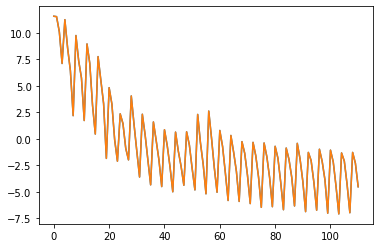

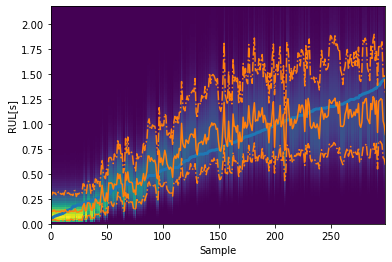

 56%|█████▌    | 111/200 [04:07<02:58,  2.01s/it]

nnodes: 10, seq_range 100 epoch: 111


 56%|█████▌    | 112/200 [04:09<03:17,  2.25s/it]

loss: -7.321, val_loss -7.321
lr_decay: setting lr to 0.00048
nnodes: 1, seq_range 2 epoch: 112


 56%|█████▋    | 113/200 [04:10<02:43,  1.88s/it]

loss: -1.558, val_loss -1.558
lr_decay: setting lr to 0.00048
nnodes: 2, seq_range 20 epoch: 113


 57%|█████▋    | 114/200 [04:12<02:30,  1.75s/it]

loss: -1.228, val_loss -1.228
lr_decay: setting lr to 0.00048
nnodes: 5, seq_range 50 epoch: 114


 57%|█████▊    | 115/200 [04:14<02:33,  1.80s/it]

loss: -4.109, val_loss -4.109
lr_decay: setting lr to 0.00047
nnodes: 10, seq_range 100 epoch: 115


 58%|█████▊    | 116/200 [04:17<02:59,  2.13s/it]

loss: -7.176, val_loss -7.176
lr_decay: setting lr to 0.00047
nnodes: 1, seq_range 2 epoch: 116


 58%|█████▊    | 117/200 [04:18<02:29,  1.80s/it]

loss: -1.348, val_loss -1.348
lr_decay: setting lr to 0.00046
nnodes: 2, seq_range 20 epoch: 117


 59%|█████▉    | 118/200 [04:19<02:18,  1.69s/it]

loss: -1.846, val_loss -1.846
lr_decay: setting lr to 0.00046
nnodes: 5, seq_range 50 epoch: 118


 60%|█████▉    | 119/200 [04:21<02:21,  1.75s/it]

loss: -4.290, val_loss -4.290
lr_decay: setting lr to 0.00045
nnodes: 10, seq_range 100 epoch: 119


 60%|██████    | 120/200 [04:24<02:45,  2.07s/it]

loss: -7.254, val_loss -7.254
lr_decay: setting lr to 0.00045
nnodes: 1, seq_range 2 epoch: 120
loss: -1.645, val_loss -1.645
lr_decay: setting lr to 0.00044


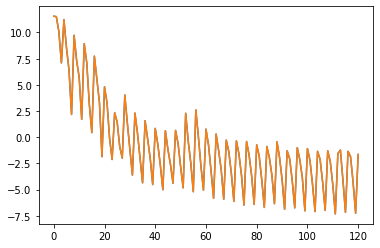

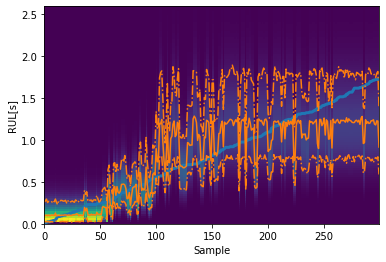

 60%|██████    | 121/200 [04:26<02:39,  2.02s/it]

nnodes: 2, seq_range 20 epoch: 121


 61%|██████    | 122/200 [04:27<02:22,  1.83s/it]

loss: -1.267, val_loss -1.267
lr_decay: setting lr to 0.00044
nnodes: 5, seq_range 50 epoch: 122


 62%|██████▏   | 123/200 [04:29<02:23,  1.86s/it]

loss: -4.042, val_loss -4.042
lr_decay: setting lr to 0.00043
nnodes: 10, seq_range 100 epoch: 123


 62%|██████▏   | 124/200 [04:32<02:42,  2.14s/it]

loss: -7.216, val_loss -7.216
lr_decay: setting lr to 0.00043
nnodes: 1, seq_range 2 epoch: 124


 62%|██████▎   | 125/200 [04:33<02:15,  1.80s/it]

loss: -1.497, val_loss -1.497
lr_decay: setting lr to 0.00043
nnodes: 2, seq_range 20 epoch: 125


 63%|██████▎   | 126/200 [04:34<02:04,  1.69s/it]

loss: -1.975, val_loss -1.975
lr_decay: setting lr to 0.00042
nnodes: 5, seq_range 50 epoch: 126


 64%|██████▎   | 127/200 [04:36<02:09,  1.78s/it]

loss: -4.283, val_loss -4.283
lr_decay: setting lr to 0.00042
nnodes: 10, seq_range 100 epoch: 127


 64%|██████▍   | 128/200 [04:39<02:30,  2.09s/it]

loss: -7.389, val_loss -7.389
lr_decay: setting lr to 0.00041
nnodes: 1, seq_range 2 epoch: 128


 64%|██████▍   | 129/200 [04:40<02:06,  1.78s/it]

loss: -1.315, val_loss -1.315
lr_decay: setting lr to 0.00041
nnodes: 2, seq_range 20 epoch: 129


 65%|██████▌   | 130/200 [04:42<01:56,  1.66s/it]

loss: -2.191, val_loss -2.191
lr_decay: setting lr to 0.00040
nnodes: 5, seq_range 50 epoch: 130
loss: -4.502, val_loss -4.502
lr_decay: setting lr to 0.00040


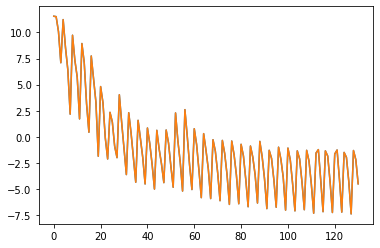

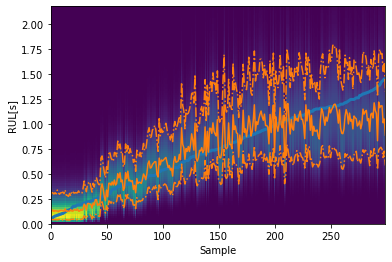

 66%|██████▌   | 131/200 [04:44<02:18,  2.01s/it]

nnodes: 10, seq_range 100 epoch: 131


 66%|██████▌   | 132/200 [04:47<02:32,  2.25s/it]

loss: -7.522, val_loss -7.522
lr_decay: setting lr to 0.00040
nnodes: 1, seq_range 2 epoch: 132


 66%|██████▋   | 133/200 [04:48<02:05,  1.88s/it]

loss: -1.447, val_loss -1.447
lr_decay: setting lr to 0.00039
nnodes: 2, seq_range 20 epoch: 133


 67%|██████▋   | 134/200 [04:50<01:54,  1.73s/it]

loss: -2.302, val_loss -2.302
lr_decay: setting lr to 0.00039
nnodes: 5, seq_range 50 epoch: 134


 68%|██████▊   | 135/200 [04:51<01:55,  1.78s/it]

loss: -4.638, val_loss -4.638
lr_decay: setting lr to 0.00038
nnodes: 10, seq_range 100 epoch: 135


 68%|██████▊   | 136/200 [04:54<02:16,  2.13s/it]

loss: -7.697, val_loss -7.697
lr_decay: setting lr to 0.00038
nnodes: 1, seq_range 2 epoch: 136


 68%|██████▊   | 137/200 [04:55<01:53,  1.80s/it]

loss: -1.673, val_loss -1.673
lr_decay: setting lr to 0.00038
nnodes: 2, seq_range 20 epoch: 137


 69%|██████▉   | 138/200 [04:57<01:44,  1.69s/it]

loss: -2.471, val_loss -2.471
lr_decay: setting lr to 0.00037
nnodes: 5, seq_range 50 epoch: 138


 70%|██████▉   | 139/200 [04:59<01:47,  1.76s/it]

loss: -4.831, val_loss -4.831
lr_decay: setting lr to 0.00037
nnodes: 10, seq_range 100 epoch: 139


 70%|███████   | 140/200 [05:02<02:04,  2.08s/it]

loss: -7.801, val_loss -7.801
lr_decay: setting lr to 0.00037
nnodes: 1, seq_range 2 epoch: 140
loss: -1.805, val_loss -1.805
lr_decay: setting lr to 0.00036


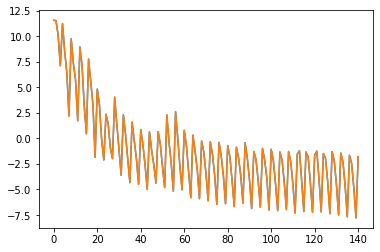

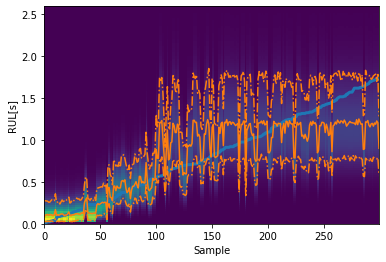

 70%|███████   | 141/200 [05:03<01:59,  2.02s/it]

nnodes: 2, seq_range 20 epoch: 141


 71%|███████   | 142/200 [05:05<01:45,  1.83s/it]

loss: -3.044, val_loss -3.044
lr_decay: setting lr to 0.00036
nnodes: 5, seq_range 50 epoch: 142


 72%|███████▏  | 143/200 [05:07<01:46,  1.87s/it]

loss: -5.034, val_loss -5.034
lr_decay: setting lr to 0.00036
nnodes: 10, seq_range 100 epoch: 143


 72%|███████▏  | 144/200 [05:10<01:59,  2.13s/it]

loss: -7.911, val_loss -7.911
lr_decay: setting lr to 0.00035
nnodes: 1, seq_range 2 epoch: 144


 72%|███████▎  | 145/200 [05:11<01:39,  1.82s/it]

loss: -1.995, val_loss -1.995
lr_decay: setting lr to 0.00035
nnodes: 2, seq_range 20 epoch: 145


 73%|███████▎  | 146/200 [05:12<01:32,  1.72s/it]

loss: -3.188, val_loss -3.188
lr_decay: setting lr to 0.00034
nnodes: 5, seq_range 50 epoch: 146


 74%|███████▎  | 147/200 [05:14<01:34,  1.78s/it]

loss: -5.174, val_loss -5.174
lr_decay: setting lr to 0.00034
nnodes: 10, seq_range 100 epoch: 147


 74%|███████▍  | 148/200 [05:17<01:48,  2.09s/it]

loss: -8.019, val_loss -8.019
lr_decay: setting lr to 0.00034
nnodes: 1, seq_range 2 epoch: 148


 74%|███████▍  | 149/200 [05:18<01:30,  1.78s/it]

loss: -2.138, val_loss -2.138
lr_decay: setting lr to 0.00033
nnodes: 2, seq_range 20 epoch: 149


 75%|███████▌  | 150/200 [05:19<01:22,  1.66s/it]

loss: -3.284, val_loss -3.284
lr_decay: setting lr to 0.00033
nnodes: 5, seq_range 50 epoch: 150
loss: -5.239, val_loss -5.239
lr_decay: setting lr to 0.00033


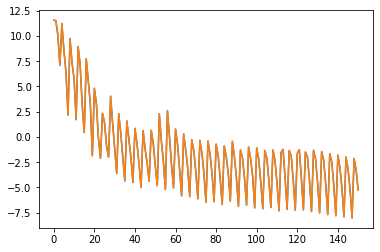

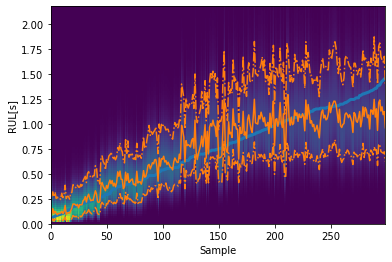

 76%|███████▌  | 151/200 [05:22<01:38,  2.00s/it]

nnodes: 10, seq_range 100 epoch: 151


 76%|███████▌  | 152/200 [05:25<01:47,  2.24s/it]

loss: -8.076, val_loss -8.076
lr_decay: setting lr to 0.00032
nnodes: 1, seq_range 2 epoch: 152


 76%|███████▋  | 153/200 [05:26<01:28,  1.88s/it]

loss: -2.221, val_loss -2.221
lr_decay: setting lr to 0.00032
nnodes: 2, seq_range 20 epoch: 153


 77%|███████▋  | 154/200 [05:27<01:19,  1.72s/it]

loss: -3.352, val_loss -3.352
lr_decay: setting lr to 0.00032
nnodes: 5, seq_range 50 epoch: 154


 78%|███████▊  | 155/200 [05:29<01:20,  1.78s/it]

loss: -5.312, val_loss -5.312
lr_decay: setting lr to 0.00031
nnodes: 10, seq_range 100 epoch: 155


 78%|███████▊  | 156/200 [05:32<01:33,  2.13s/it]

loss: -8.143, val_loss -8.143
lr_decay: setting lr to 0.00031
nnodes: 1, seq_range 2 epoch: 156


 78%|███████▊  | 157/200 [05:33<01:17,  1.79s/it]

loss: -2.311, val_loss -2.311
lr_decay: setting lr to 0.00031
nnodes: 2, seq_range 20 epoch: 157


 79%|███████▉  | 158/200 [05:35<01:09,  1.66s/it]

loss: -3.412, val_loss -3.412
lr_decay: setting lr to 0.00031
nnodes: 5, seq_range 50 epoch: 158


 80%|███████▉  | 159/200 [05:36<01:11,  1.74s/it]

loss: -5.341, val_loss -5.341
lr_decay: setting lr to 0.00030
nnodes: 10, seq_range 100 epoch: 159


 80%|████████  | 160/200 [05:39<01:23,  2.08s/it]

loss: -8.178, val_loss -8.178
lr_decay: setting lr to 0.00030
nnodes: 1, seq_range 2 epoch: 160
loss: -2.366, val_loss -2.366
lr_decay: setting lr to 0.00030


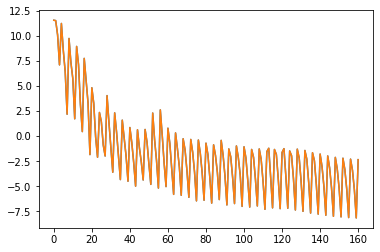

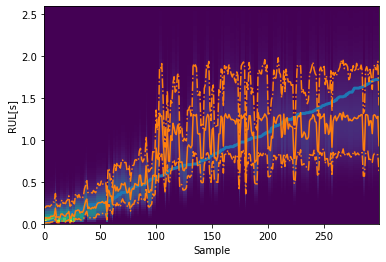

 80%|████████  | 161/200 [05:41<01:17,  1.98s/it]

nnodes: 2, seq_range 20 epoch: 161


 81%|████████  | 162/200 [05:42<01:08,  1.80s/it]

loss: -3.453, val_loss -3.453
lr_decay: setting lr to 0.00029
nnodes: 5, seq_range 50 epoch: 162


 82%|████████▏ | 163/200 [05:44<01:08,  1.84s/it]

loss: -5.383, val_loss -5.383
lr_decay: setting lr to 0.00029
nnodes: 10, seq_range 100 epoch: 163


 82%|████████▏ | 164/200 [05:47<01:17,  2.16s/it]

loss: -8.220, val_loss -8.220
lr_decay: setting lr to 0.00029
nnodes: 1, seq_range 2 epoch: 164


 82%|████████▎ | 165/200 [05:48<01:03,  1.81s/it]

loss: -2.425, val_loss -2.425
lr_decay: setting lr to 0.00028
nnodes: 2, seq_range 20 epoch: 165


 83%|████████▎ | 166/200 [05:50<00:57,  1.69s/it]

loss: -3.494, val_loss -3.494
lr_decay: setting lr to 0.00028
nnodes: 5, seq_range 50 epoch: 166


 84%|████████▎ | 167/200 [05:52<00:57,  1.75s/it]

loss: -5.419, val_loss -5.419
lr_decay: setting lr to 0.00028
nnodes: 10, seq_range 100 epoch: 167


 84%|████████▍ | 168/200 [05:54<01:06,  2.07s/it]

loss: -8.257, val_loss -8.257
lr_decay: setting lr to 0.00028
nnodes: 1, seq_range 2 epoch: 168


 84%|████████▍ | 169/200 [05:55<00:54,  1.75s/it]

loss: -2.473, val_loss -2.473
lr_decay: setting lr to 0.00027
nnodes: 2, seq_range 20 epoch: 169


 85%|████████▌ | 170/200 [05:57<00:49,  1.66s/it]

loss: -3.517, val_loss -3.517
lr_decay: setting lr to 0.00027
nnodes: 5, seq_range 50 epoch: 170
loss: -5.439, val_loss -5.439
lr_decay: setting lr to 0.00027


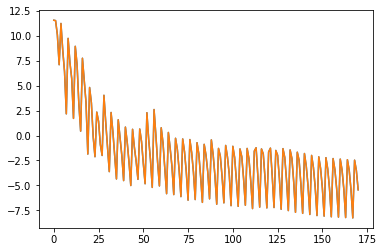

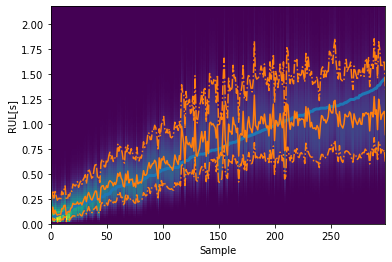

 86%|████████▌ | 171/200 [06:00<00:57,  2.00s/it]

nnodes: 10, seq_range 100 epoch: 171


 86%|████████▌ | 172/200 [06:02<01:02,  2.24s/it]

loss: -8.277, val_loss -8.277
lr_decay: setting lr to 0.00027
nnodes: 1, seq_range 2 epoch: 172


 86%|████████▋ | 173/200 [06:04<00:50,  1.88s/it]

loss: -2.515, val_loss -2.515
lr_decay: setting lr to 0.00026
nnodes: 2, seq_range 20 epoch: 173


 87%|████████▋ | 174/200 [06:05<00:45,  1.75s/it]

loss: -3.532, val_loss -3.532
lr_decay: setting lr to 0.00026
nnodes: 5, seq_range 50 epoch: 174


 88%|████████▊ | 175/200 [06:07<00:44,  1.80s/it]

loss: -5.460, val_loss -5.460
lr_decay: setting lr to 0.00026
nnodes: 10, seq_range 100 epoch: 175


 88%|████████▊ | 176/200 [06:10<00:51,  2.13s/it]

loss: -8.292, val_loss -8.292
lr_decay: setting lr to 0.00025
nnodes: 1, seq_range 2 epoch: 176


 88%|████████▊ | 177/200 [06:11<00:41,  1.82s/it]

loss: -2.541, val_loss -2.541
lr_decay: setting lr to 0.00025
nnodes: 2, seq_range 20 epoch: 177


 89%|████████▉ | 178/200 [06:12<00:37,  1.69s/it]

loss: -3.550, val_loss -3.550
lr_decay: setting lr to 0.00025
nnodes: 5, seq_range 50 epoch: 178


 90%|████████▉ | 179/200 [06:14<00:36,  1.76s/it]

loss: -5.494, val_loss -5.494
lr_decay: setting lr to 0.00025
nnodes: 10, seq_range 100 epoch: 179


 90%|█████████ | 180/200 [06:17<00:42,  2.11s/it]

loss: -8.311, val_loss -8.311
lr_decay: setting lr to 0.00024
nnodes: 1, seq_range 2 epoch: 180
loss: -2.558, val_loss -2.558
lr_decay: setting lr to 0.00024


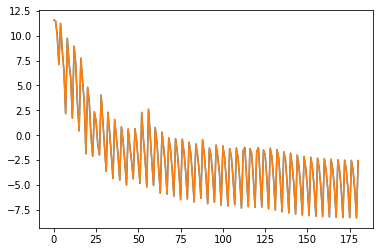

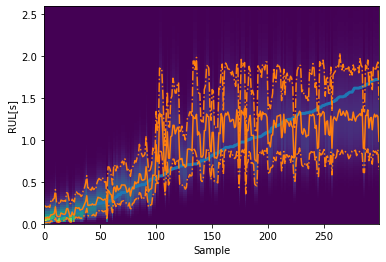

 90%|█████████ | 181/200 [06:19<00:38,  2.01s/it]

nnodes: 2, seq_range 20 epoch: 181


 91%|█████████ | 182/200 [06:20<00:32,  1.83s/it]

loss: -3.559, val_loss -3.559
lr_decay: setting lr to 0.00024
nnodes: 5, seq_range 50 epoch: 182


 92%|█████████▏| 183/200 [06:22<00:31,  1.84s/it]

loss: -5.500, val_loss -5.500
lr_decay: setting lr to 0.00024
nnodes: 10, seq_range 100 epoch: 183


 92%|█████████▏| 184/200 [06:25<00:34,  2.16s/it]

loss: -8.300, val_loss -8.300
lr_decay: setting lr to 0.00024
nnodes: 1, seq_range 2 epoch: 184


 92%|█████████▎| 185/200 [06:26<00:27,  1.82s/it]

loss: -2.566, val_loss -2.566
lr_decay: setting lr to 0.00023
nnodes: 2, seq_range 20 epoch: 185


 93%|█████████▎| 186/200 [06:28<00:23,  1.71s/it]

loss: -3.562, val_loss -3.562
lr_decay: setting lr to 0.00023
nnodes: 5, seq_range 50 epoch: 186


 94%|█████████▎| 187/200 [06:29<00:22,  1.76s/it]

loss: -5.500, val_loss -5.500
lr_decay: setting lr to 0.00023
nnodes: 10, seq_range 100 epoch: 187


 94%|█████████▍| 188/200 [06:32<00:25,  2.09s/it]

loss: -8.284, val_loss -8.284
lr_decay: setting lr to 0.00023
nnodes: 1, seq_range 2 epoch: 188


 94%|█████████▍| 189/200 [06:33<00:19,  1.78s/it]

loss: -2.564, val_loss -2.564
lr_decay: setting lr to 0.00022
nnodes: 2, seq_range 20 epoch: 189


 95%|█████████▌| 190/200 [06:35<00:16,  1.69s/it]

loss: -3.583, val_loss -3.583
lr_decay: setting lr to 0.00022
nnodes: 5, seq_range 50 epoch: 190
loss: -5.521, val_loss -5.521
lr_decay: setting lr to 0.00022


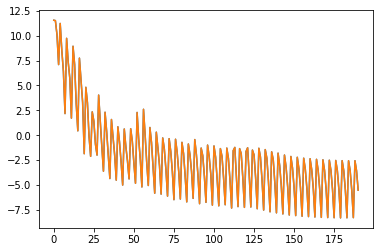

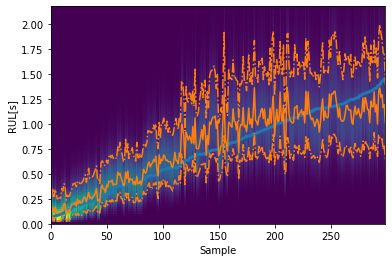

 96%|█████████▌| 191/200 [06:38<00:18,  2.00s/it]

nnodes: 10, seq_range 100 epoch: 191


 96%|█████████▌| 192/200 [06:40<00:18,  2.27s/it]

loss: -8.331, val_loss -8.331
lr_decay: setting lr to 0.00022
nnodes: 1, seq_range 2 epoch: 192


 96%|█████████▋| 193/200 [06:41<00:13,  1.89s/it]

loss: -2.588, val_loss -2.588
lr_decay: setting lr to 0.00021
nnodes: 2, seq_range 20 epoch: 193


 97%|█████████▋| 194/200 [06:43<00:10,  1.75s/it]

loss: -3.690, val_loss -3.690
lr_decay: setting lr to 0.00021
nnodes: 5, seq_range 50 epoch: 194


 98%|█████████▊| 195/200 [06:45<00:08,  1.80s/it]

loss: -5.592, val_loss -5.592
lr_decay: setting lr to 0.00021
nnodes: 10, seq_range 100 epoch: 195


 98%|█████████▊| 196/200 [06:48<00:08,  2.09s/it]

loss: -8.424, val_loss -8.424
lr_decay: setting lr to 0.00021
nnodes: 1, seq_range 2 epoch: 196


 98%|█████████▊| 197/200 [06:49<00:05,  1.77s/it]

loss: -2.726, val_loss -2.726
lr_decay: setting lr to 0.00021
nnodes: 2, seq_range 20 epoch: 197


 99%|█████████▉| 198/200 [06:50<00:03,  1.67s/it]

loss: -3.825, val_loss -3.825
lr_decay: setting lr to 0.00020
nnodes: 5, seq_range 50 epoch: 198


100%|█████████▉| 199/200 [06:52<00:01,  1.75s/it]

loss: -5.712, val_loss -5.712
lr_decay: setting lr to 0.00020
nnodes: 10, seq_range 100 epoch: 199


100%|██████████| 200/200 [06:55<00:00,  2.08s/it]

loss: -8.550, val_loss -8.550
lr_decay: setting lr to 0.00020


In [25]:
n_epochs = 200
nnodes_schedule = [1,2,5,10]
nseq_range_schedule = [2,20,50,100]
min_spacing_schedule = [1,5,5,5]
iterations_schedule = [5]
nbatch = 300
val_pct = 0.2 # percentage of sequence samples from the **seen ** experiments used as a validation set.
fixed_spacing_indices = False

eval_mode = "batched"
from tqdm import tqdm
for i in tqdm(range(n_epochs)):
    np.random.seed(42); 
    epoch = i
    
    # This makes sure that I always get different training and validation sets (there can still be some overlap but training should work ok)
    nnodes      = nnodes_schedule[i%len(nnodes_schedule)]
    nseq_range  = nseq_range_schedule[i%len(nseq_range_schedule)]
    min_spacing = min_spacing_schedule[i%len(min_spacing_schedule)]
    iterations = iterations_schedule[i%len(iterations_schedule)]
    
    if (nnodes * min_spacing) > nseq_range:
        min_spacing = 10
        nseq_range = nnodes * min_spacing+10
        
    print("nnodes: %i, seq_range %i epoch: %i"%(nnodes, nseq_range, i))
    curr_data = get_multi_batch_fictitious(nbatch, source_ds=True,nnodes=nnodes,
                                min_spacing = min_spacing,
                                nseq_range = nseq_range,
                                fixed_spacing_indices=fixed_spacing_indices);
    
    loss_epoch = 0;
    val_loss_epoch = 0;
    
    for single_minibatch in curr_data:
        with tf.GradientTape() as tape:
            graph_curr, y_curr = single_minibatch;
            #print(graph_curr)
            #def eval_graphnets_loss(graph_curr_, ycurr_,iterations):
            prob_out = gn_tot.eval_graphnets(graph_curr.copy(), iterations, eval_mode=eval_mode)
            loss_vals = -prob_out.log_prob(y_curr[np.newaxis].T)
            #ycurr_t = y_curr[np.newaxis].T
            #ycurr_t = tf.Variable(ycurr_t)
            #loss_vals=  eval_graphnets_loss(graph_curr.copy(), ycurr_t, tf.constant(iterations))
            
            all_weights =gn_tot.weights() 
            
            
            train_loss = loss_vals[0:int(nbatch*(1-val_pct))];
            
            grads = tape.gradient(train_loss, all_weights)
            all_weights_filt = [all_weights[k] for k in range(len(grads)) if grads[k] is not None]
            grads_filt = [grads[k] for k in range(len(grads)) if grads[k] is not None]
            opt.apply_gradients(zip(grads_filt, all_weights_filt))
            loss_epoch += train_loss/len(y_curr)
        
        val_loss_epoch += tf.reduce_mean(loss_vals[int(-nbatch*(val_pct)):])
        
    loss_log.append_loss(np.sum(loss_epoch.numpy()))
    loss_log.append_val_loss(np.sum(val_loss_epoch.numpy()))
    loss_log.print()
    lr_scheduler.on_epoch_end(epoch)
    if early_stop.on_epoch_end(epoch):
        break
        
    if epoch%10 == 0:
        pplot.plot(loss_log.loss_history['loss'])
        pplot.plot(loss_log.loss_history['val_loss'])
        pplot.show()
        plot_experiment_fit(curr_data[0])
        pplot.show()

In [29]:
#plot_experiment_fit()
#curr_data[2]

In [30]:
#graph_indep.graph_eval(graph_data_.copy())
#graph_data_.nodes[0].node_attr_tensor.shape

In [31]:
pplot.plot(loss_log.loss_history['val_loss'])
pplot.show()

NameError: name 'loss_log' is not defined

In [32]:
help(get_graph_data_multiple_experiments)


    

Help on function get_graph_data_multiple_experiments in module utils:

get_graph_data_multiple_experiments(experiments, X_=None, eid_oh_=None, yrem_norm_=None, nsamples_per_experiment=None, nnodes=None, min_spacing=None, nseq_range=None, fixed_spacing_indices=False)



In [33]:
len(test_data)

3

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'prob'

<Figure size 1440x720 with 0 Axes>

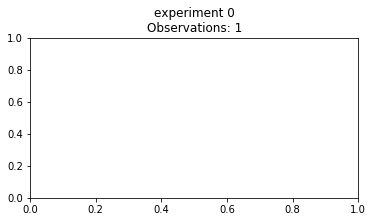

In [34]:
from IPython.display import clear_output
min_spacing = 5;
nseq_range = 100
pplot.figure(figsize = (20,10));
for nnodes in [1,2,5,10]:
#nnodes = 2

    pplot.figure(figsize = (20,10));

    test_data = get_graph_data_multiple_experiments(fic.inds_exp_target,fic.X, eid_oh_ = fic.eid_oh, yrem_norm_ = fic.yrem_norm ,
                                           nsamples_per_experiment = 500, nnodes = nnodes, min_spacing = min_spacing, nseq_range=nseq_range)

    for idx_experiment,data in enumerate(test_data):
        pplot.subplot(3,3,idx_experiment +1, title = "experiment {}\nObservations: {}".format(idx_experiment, nnodes))
        plot_experiment_fit(data, iterations=5, colorscale_fn = lambda x : x,max_time = 2., cmap = "gray")
    pplot.subplots_adjust(wspace=0.5, hspace = 0.5)

In [20]:
graph = train_data[0][0]
n = graph.nodes[0]


NameError: name 'train_data' is not defined

In [21]:
pplot.plot(graph.node_times[0])

NameError: name 'graph' is not defined

In [46]:
graphs = gn_tot.eval_graphnets(train_data[2][0].copy())

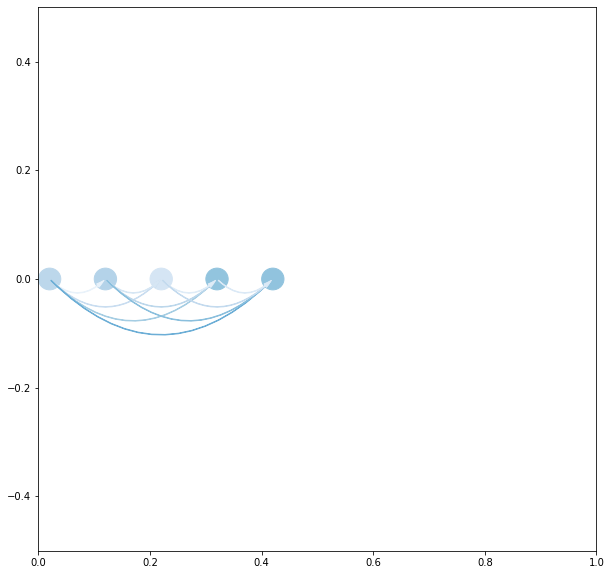

In [41]:
from matplotlib import patches

        
def plot_between_points(from_, to_, **kw_points):
    style = "Simple, tail_width=0.5, head_width=4, head_length=8"
    
    kw_points.update({"arrowstyle" : style})
    a = patches.FancyArrowPatch((from_.center[0],from_.center[1]), (to_.center[0], to_.center[1]),
                                 connectionstyle="arc3,rad=.5", **kw_points)
    
    return a

def graph_patches(g, index_to_plot = 0, derive_node_values = None, xlims = [0,1], sc = 0.1, node_coords = None,node_radious = 0.1,
                  edge_value_to_color = lambda ev : None,
                  node_value_to_color = lambda nc : None, cmap = "copper", node_text = True):
    
    nodes_dict = {n:n.node_attr_tensor[index_to_plot,...] for n in g.nodes}
    edges_dict = {e:e.edge_tensor[index_to_plot,...] for e in g.edges}
    
    edge_cmap  =pplot.get_cmap(cmap)
    node_cmap  =pplot.get_cmap(cmap)
    
    # I use a dictionary so I can resolve connectivity easier.
    #if derive_node_values is None:
    #    node_values = [1.*sc for k in nodes_dict.values()]
    
    node_colors = [] 
    if node_coords is None:
        node_coords_x = [float(k)*0.1-xlims[0]+node_radious for k in range(0, len(nodes_dict))]
        node_coords_y = [0. for kk in node_coords_x];
    
    
    # node patches:
    node_patches = {};
    for n,ncx,ncy in zip(nodes_dict.keys(),node_coords_x, node_coords_y):
        node_color = node_value_to_color(nodes_dict[n])
        node_color_rgb = node_cmap(node_color)
        node_patch_val = {n:patches.Circle((ncx,ncy,0), node_radious, color = node_color_rgb)}
        node_patches.update(node_patch_val)
        
    # edge patches:
    edge_patches = {};
    for ek, ev in zip(edges_dict.keys(), edges_dict.values()):
        
        patch_from = node_patches[ek.node_from]
        patch_to = node_patches[ek.node_to]
        
        edge_color_val = edge_value_to_color(ev)
        if edge_color_val is not None:
            edge_color_val = edge_cmap(edge_color_val)
            
        edge_patches.update({ek : plot_between_points(patch_from, patch_to, color = edge_color_val)})
    
        
    # make node patches:
    return [p_ for p_ in node_patches.values()] , [ep for ep in edge_patches.values()]


p,e = graph_patches(graph,0, sc = 0.03,
                    edge_value_to_color = lambda ev : np.linalg.norm(ev),
                    node_value_to_color = lambda vv : np.max(np.abs(vv)),
                    node_radious = 0.02, cmap = "Blues")
fig, ax = pplot.subplots(figsize = (10,10))
ax.set_xlim([0,1])
ax.set_ylim([-0.5,0.5])
for p_ in p:
    ax.add_patch(p_)

for e_ in e:
    ax.add_patch(e_)




In [ ]:
class DraggableGraphNodes(self,node_cirle):
    def __init__(self, node):
        self.node = node
        self.press = None
        
    def connect(self):
        self.cidpress = self.

In [329]:
%matplotlib qt5
import numpy as np
import matplotlib.pyplot as plt

class DraggableRectangle:
    def __init__(self, rect):
        self.rect = rect
        self.press = None

    def connect(self):
        'connect to all the events we need'
#         self.cidpress = self.rect.figure.canvas.mpl_connect(
#             'button_press_event', self.on_press)
#         self.cidrelease = self.rect.figure.canvas.mpl_connect(
#             'button_release_event', self.on_release)
        self.cidpress = self.rect.figure.canvas.mpl_connect(
            'figure_enter_event', self.on_press)
        self.cidrelease = self.rect.figure.canvas.mpl_connect(
            'figure_leave_event', self.on_release)

        self.cidmotion = self.rect.figure.canvas.mpl_connect(
            'motion_notify_event', self.on_motion)

    def on_press(self, event):
        'on button press we will see if the mouse is over us and store some data'
        if event.inaxes != self.rect.axes: return

        contains, attrd = self.rect.contains(event)
        if not contains: return
        print('event contains', self.rect.xy)
        x0, y0 = self.rect.xy
        self.press = x0, y0, event.xdata, event.ydata

    def on_motion(self, event):
        'on motion we will move the rect if the mouse is over us'
        if self.press is None: return
        if event.inaxes != self.rect.axes: return
        x0, y0, xpress, ypress = self.press
        dx = event.xdata - xpress
        dy = event.ydata - ypress
        #print('x0=%f, xpress=%f, event.xdata=%f, dx=%f, x0+dx=%f' %
        #      (x0, xpress, event.xdata, dx, x0+dx))
        self.rect.set_x(x0+dx)
        self.rect.set_y(y0+dy)

        self.rect.figure.canvas.draw()


    def on_release(self, event):
        'on release we reset the press data'
        self.press = None
        self.rect.figure.canvas.draw()

    def disconnect(self):
        'disconnect all the stored connection ids'
        self.rect.figure.canvas.mpl_disconnect(self.cidpress)
        self.rect.figure.canvas.mpl_disconnect(self.cidrelease)
        self.rect.figure.canvas.mpl_disconnect(self.cidmotion)

fig = plt.figure()
ax = fig.add_subplot(111)
rects = ax.bar(range(10), 20*np.random.rand(10))
drs = []
for rect in rects:
    dr = DraggableRectangle(rect)
    dr.connect()
    drs.append(dr)

plt.show()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/GraphNet_Fictitious/core/node_function/assets
INFO:tensorflow:Assets written to: /tmp/GraphNet_Fictitious/core/edge_aggregation_function/assets
INFO:tensorflow:Assets written to: /tmp/GraphNet_Fictitious/core/edge_function/assets
INFO:tensorflow:Assets written to: /tmp/GraphNet_Fictitious/core/node_to_prob/assets
INFO:tensorflow:Assets written to: /tmp/GraphNet_Fictitious/graph_independent/node_function/assets
INFO:tensorflow:Assets written to: /tmp/GraphNet_Fictitious/graph_independent/edge_function/assets


In [254]:
p[0].center

(0.0, 0)

In [211]:
help(patches.Polygon)

Help on class Polygon in module matplotlib.patches:

class Polygon(Patch)
 |  A general polygon patch.
 |  
 |  Method resolution order:
 |      Polygon
 |      Patch
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, xy, closed=True, **kwargs)
 |      *xy* is a numpy array with shape Nx2.
 |      
 |      If *closed* is *True*, the polygon will be closed so the
 |      starting and ending points are the same.
 |      
 |      Valid kwargs are:
 |        agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
 |        alpha: float or None
 |        animated: bool
 |        antialiased or aa: unknown
 |        capstyle: {'butt', 'round', 'projecting'}
 |        clip_box: `.Bbox`
 |        clip_on: bool
 |        clip_path: [(`~matplotlib.path.Path`, `.Transform`) | `.Patch` | None]
 |        color: color
 |        contains: callable
 |        edgecolor or ec: color or 

Help on function arrow in module matplotlib.pyplot:

arrow(x, y, dx, dy, **kwargs)
    Add an arrow to the axes.
    
    This draws an arrow from ``(x, y)`` to ``(x+dx, y+dy)``.
    
    Parameters
    ----------
    x, y : float
        The x and y coordinates of the arrow base.
    dx, dy : float
        The length of the arrow along x and y direction.
    
    Returns
    -------
    arrow : `.FancyArrow`
        The created `.FancyArrow` object.
    
    Other Parameters
    ----------------
    **kwargs
        Optional kwargs (inherited from `.FancyArrow` patch) control the
        arrow construction and properties:
    
    Constructor arguments
      *width*: float (default: 0.001)
        width of full arrow tail
    
      *length_includes_head*: bool (default: False)
        True if head is to be counted in calculating the length.
    
      *head_width*: float or None (default: 3*width)
        total width of the full arrow head
    
      *head_length*: float or None (def

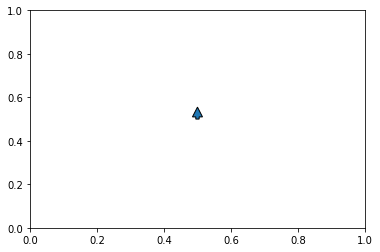

In [233]:
help(pplot.arrow)
pplot.arrow(0.5,0.5,0.0,0.01, width = 0.01,shape= "full")

In [32]:
# a whole experiment:
exp_idx = 2
d = get_dat(all_dat[exp_idx])
y = d['y']
X = d['X'][...,np.newaxis]
n = Node(X)
g = Graph([n],[])
vals = eval_graphnets(g.copy())

## Graph with two observations with a certain time interval between them:
dist_measurements = 20; # distance between measurements
spacing_readings = 1;
y2_0= d['y'][0:-dist_measurements:spacing_readings]
y2_1= d['y'][dist_measurements::spacing_readings]
X0 = d['X'][0:-dist_measurements:spacing_readings][..., np.newaxis]
X1 = d['X'][dist_measurements::spacing_readings][..., np.newaxis]
n0 = Node(X0)
n1 = Node(X1)
e01 = Edge(node_from = n0,node_to = n1, edge_attr_tensor=(y2_1 - y2_0)[:,np.newaxis])
g2 = Graph([n0,n1], [e01])
vals2 = eval_graphnets(g2.copy())


## Graph with three observations with a certain time interval between them:
dist_measurements = 20; # distance between measurements
spacing_readings = 1;
y2_0= d['y'][0:-dist_measurements:spacing_readings]
y2_1= d['y'][dist_measurements::spacing_readings]
X0 = d['X'][0:-dist_measurements:spacing_readings][..., np.newaxis]
X1 = d['X'][dist_measurements::spacing_readings][..., np.newaxis]
n0 = Node(X0)
n1 = Node(X1)
e01 = Edge(node_from = n0,node_to = n1, edge_attr_tensor=(y2_1 - y2_0)[:,np.newaxis])
g2 = Graph([n0,n1], [e01])
vals2 = eval_graphnets(g2.copy())

NameError: name 'all_dat' is not defined

-0.9023638633306188

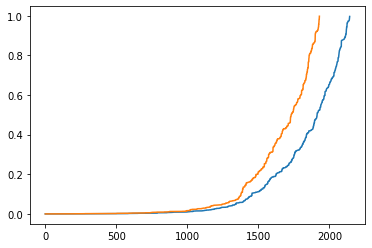

In [255]:
pplot.plot(((latent[0]['latent_values'])/250)**2)
pplot.plot(((latent[2]['latent_values']/250))**2)
np.random.randn()


In [485]:
#graph_indep.graph_eval(g2.copy())
#graph_data_val[0].edges[0].edge_tensor.shape#e01.edge_tensor.shape


In [486]:

X0.shape,X1.shape

((208, 1000, 1), (208, 1000, 1))

AttributeError: 'numpy.ndarray' object has no attribute 'prob'

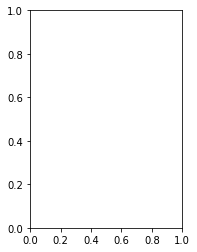

In [38]:
pplot.subplot(1,2,1)
#predictions_val[ids_sort.flatten()]
v = vals.prob(times).numpy().T
pplot.pcolor([r for r in range(v.shape[1])],times*350,v)
# pplot.yscale("log")
# pplot.semilogy(y,"C1")
pplot.plot(y, "C1")

pplot.subplot(1,2,2)
v = vals2.prob(times).numpy().T
pplot.pcolor([r for r in range(v.shape[1])],times*350,v)
#pplot.yscale("log")
#pplot.semilogy(y2_1,"C1")
pplot.plot(y2_1,"C1")


# Done. Success.